## Introduction

This study aims to analyze user interactions with various lending protocols, providing insights into their borrowing and lending patterns. The aim of the study is achieved by loading loan data from different sources and analysing user behaviour across the lending protocols. 

## Objective
The primary objective of this study is to analyze user behavior across multiple lending protocols. We will achieve this by examining the data on loans, including user information, protocol details, collateral, and debt amounts. Our analysis will focus on answering key questions related to user engagement with different protocols, such as the number of users providing liquidity or borrowing on one or multiple protocols and the distribution of staked/borrowed capital across these protocols.

## Methodology

To conduct this analysis, we applied the following structured approach:
1. Data Loading: Create a data data load function that allows for easy switching between google storage and sql database, ensuring flexibility in data sourcing.
2. Data Visualization: Visualizing user behaviour across the lending protocols allow us to answer:
   - The number of users providing liquidity or borrowing just one protocol versus multiple protocols.
   - The distribution of borrowed capital across different lending protocols.
3. Venn Diagram Creation: Provides an overlap of user participation across different lending protocols, providing clear visual representation of multi-protocol engagement.


## Expected Outcomes

This study will not only shed light on current user engagement patterns but also pave the way for future research and development in decentralized lending and borrowing platforms.

### Importing Libraries

In [7]:
# importing necessary libraries
import os
import sys
import pandas as pd
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
from sqlalchemy import create_engine
import gcsfs
import requests
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
import re
import src.helpers
import src.main_chart
import src.persistent_state
import src.settings
import src.swap_amm
import src.utils
import math

### Loading the Data

#### From Postgress

#### From GCS

In [8]:
def load_protocol_data(protocols: list[str]) -> pd.DataFrame:
    """
    Load data from Google Storage for the specified protocols and combine them into a single DataFrame.
    
    Parameters:
    protocols (list[str]): A list of protocol names to load data for.
    
    Returns:
    pd.DataFrame: A DataFrame containing the combined data from all specified protocols.
    
    """    
    combined_protocols_df = pd.DataFrame()
    
    for protocol in protocols:
        # Read from google storage
        try:
            url = f"https://storage.googleapis.com/derisk-persistent-state/{protocol}_data/loans.parquet"      
            print(f"Processing {protocol} from Google Storage...")
            df_protocol = pd.read_parquet(url)
        except:
            #url = f"https://storage.googleapis.com/derisk-persistent-state/{protocol}_data/loans.parquet"      
            #print(f"Processing {protocol} from Google Storage...")
            #df_protocol = pd.read_parquet(url)
            print("Moving forward")
        # Read from SQL DB
        ## Uncomment the following code block and comment the above three lines to load data from a local database
        # connection = src.db.establish_connection()
        # query = f"SELECT * FROM {protocol}_data" # Ensure table name is correct
        # print(f"Processing {protocol} from local database...")
        # df_protocol = pd.read_sql(query, con = connection)
        # connection.close()
        
        df_protocol['Protocol'] = protocol
        combined_protocols_df = pd.concat([combined_protocols_df, df_protocol], ignore_index=True)
    return combined_protocols_df

# List of protocols
PROTOCOLS = ['zklend', 'nostra_alpha', 'nostra_mainnet', 'hashstack_v0', 'hashstack_v1']

# Load the data
df_loans = load_protocol_data(PROTOCOLS)
print(f"Combined dataframe shape: {df_loans.shape}")

Processing zklend from Google Storage...
Processing nostra_alpha from Google Storage...
Processing nostra_mainnet from Google Storage...
Processing hashstack_v0 from Google Storage...
Processing hashstack_v1 from Google Storage...
Combined dataframe shape: (1776234, 9)


In [9]:
df_loans.isnull().sum()

User                              0
Protocol                          0
Collateral (USD)                  0
Risk-adjusted collateral (USD)    0
Debt (USD)                        0
Health factor                     0
Standardized health factor        0
Collateral                        0
Debt                              0
dtype: int64

In [10]:
df_loans.head()

,User,Protocol,Collateral (USD),Risk-adjusted collateral (USD),Debt (USD),Health factor,Standardized health factor,Collateral,Debt
0,0x4306021e30f9577351207140f90425b3e9e102ec5a42...,zklend,5744.568231,4289.009524,22.162648,193.524234,193.524234,"USDC: 113.3876, USDT: 4610.7524, STRK: 904.5577","USDC: 10.0284, USDT: 10.0302, wstETH: 0.0006"
1,0x30b399e06903676ada3eccd5522e0cca4c4ad0101468...,zklend,37.671463,30.137170,0.000000,inf,inf,ETH: 0.0126,
2,0x2f006034f567d5c2431bc4104b2cc7a1bf8f004bd00c...,zklend,102.450086,81.960069,0.387499,211.510582,211.510582,"ETH: 0.0311, USDC: 6.5088, USDT: 3.0144",ETH: 0.0005
3,0x43e9ee859c0f85a6d5ab3f7ad26c50b9e9d8a8e10d0d...,zklend,-5.156963,-4.125570,0.000000,inf,inf,,
4,0x22dd5ed1e4d359eca2e772ecefa57e31bb7756772850...,zklend,213.311298,157.651127,0.000000,inf,inf,"wBTC: 0.0018, DAI: 23.1396, USDT: 83.3628",


### List of Current prices in USD for given tokens
Ethereum,Wrapped-Bitcoin,USD-coin,DAI,Tether,Wrapped-Steth,Lords,Strike,UNO-Re,Zenad

In [11]:
def fetch_prices(collateral_token: str) -> float:
    # Fetch underlying addresses and decimals
    collateral_token_underlying_address = (
        src.helpers.UNDERLYING_SYMBOLS_TO_UNDERLYING_ADDRESSES[collateral_token]
    )
    collateral_token_decimals = int(
        math.log10(src.settings.TOKEN_SETTINGS[collateral_token].decimal_factor)
    )
    underlying_addresses_to_decimals = {
        collateral_token_underlying_address: collateral_token_decimals
    }

    # Fetch prices
    prices = src.helpers.get_prices(token_decimals=underlying_addresses_to_decimals)
    collateral_token_price = prices[collateral_token_underlying_address]

    return collateral_token_price

In [12]:
COLLATERAL_TOKENS = ["ETH", "WBTC", "STRK", "USDC", "USDT", "DAI", "DAI V2"]
prices = {}
for token in COLLATERAL_TOKENS:
    price = fetch_prices(token)
    prices[token] = price
prices

AssertionError: 

In [5]:
# List of token IDs to fetch from CoinGecko (you can add more tokens if needed)
token_ids = 'ethereum,wrapped-bitcoin,usd-coin,dai,tether,wrapped-steth,lords,strike,uno-re,zenad'

# API endpoint
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
    'ids': token_ids,
    'vs_currencies': 'usd'
}

response = requests.get(url, params=params)
prices = response.json()

print("Token Prices in USD:", prices)


Token Prices in USD: {'dai': {'usd': 1.0}, 'ethereum': {'usd': 2487.73}, 'lords': {'usd': 0.04989956}, 'strike': {'usd': 6.52}, 'tether': {'usd': 0.998271}, 'uno-re': {'usd': 0.01199116}, 'usd-coin': {'usd': 1.0}, 'wrapped-bitcoin': {'usd': 67042}, 'wrapped-steth': {'usd': 2934.02}, 'zenad': {'usd': 0.00118212}}


### Determine User Activity
#### Users Providing Liquidity and their Protocols

In [7]:
# the distribution of protocols among users
top_protocols = df_loans['Protocol'].value_counts()
top_protocols

Protocol
zklend            1383629
nostra_mainnet     247540
nostra_alpha       143645
hashstack_v1         1289
hashstack_v0          131
Name: count, dtype: int64

### Subset the DataFrame for users who provide liquidity

In [8]:
liquidity_data = df_loans[df_loans['Collateral (USD)'] > 0]

# Initialize a dictionary to store users and their associated protocols for liquidity
user_protocols_liquidity = defaultdict(set)

# Populate the dictionary
for _, row in liquidity_data.iterrows():
    user = row['User']
    protocol = row['Protocol']
    user_protocols_liquidity[user].add(protocol)
    
# Count the number of protocols each user lends on
user_protocol_counts_liquidity = Counter([len(protocols) for protocols in user_protocols_liquidity.values()])

# Convert the counter to a DataFrame for better readability
protocol_count_df_liquidity = pd.DataFrame.from_dict(user_protocol_counts_liquidity, orient='index').reset_index()
protocol_count_df_liquidity.columns = ['Number of Protocols', 'Number of Users']

# Sort the DataFrame by the number of protocols
protocol_count_df_liquidity = protocol_count_df_liquidity.sort_values(by='Number of Protocols')

In [9]:
protocol_count_df_liquidity = protocol_count_df_liquidity.reset_index(drop = True)

In [10]:
print("Users providing liquidity:\n")
protocol_count_df_liquidity

Users providing liquidity:



,Number of Protocols,Number of Users
0,1,402964
1,2,71145
2,3,4510
3,4,15


##### Users Providing Liquidity Across the Top 3 Protocols

In [12]:
## Helper funcitons:
# Function to get unique users per protocol
def get_unique_users_by_protocol(df):
    protocol_users = defaultdict(set)
    for protocol in df['Protocol'].unique():
        users = set(df[df['Protocol'] == protocol]['User'])
        protocol_users[protocol].update(users)
    return protocol_users
    
# Helper function to plot Venn diagram
def plot_venn_diagram(user_sets, title, labels):
    plt.figure(figsize=(10, 8))
    venn3(subsets=(user_sets[0], user_sets[1], user_sets[2]), 
          set_labels=labels)
    plt.title(title)
    plt.show()

### Venn Diagram 

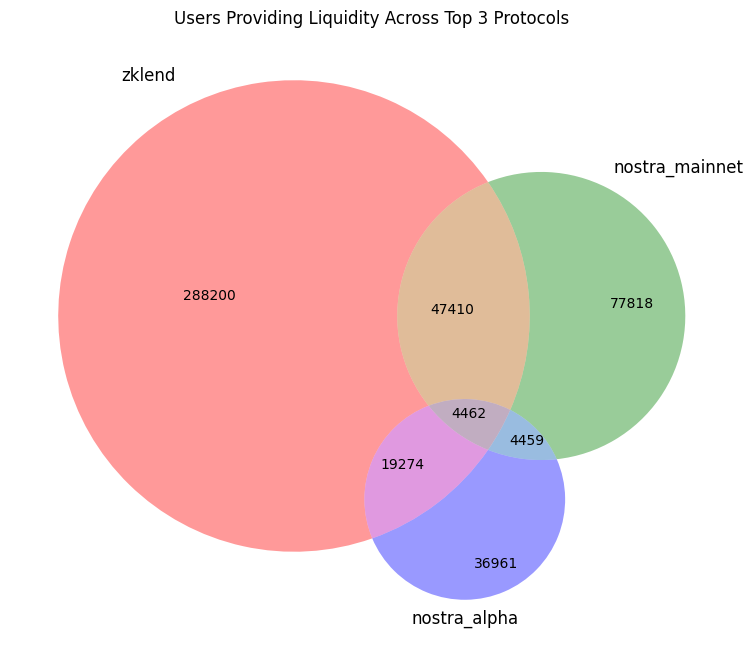

In [13]:
# Get unique users providing liquidity
liquidity_df = loans[loans['Collateral (USD)'] > 0]
liquidity_protocol_users = get_unique_users_by_protocol(liquidity_df)


# Prepare sets for Venn diagrams (top 3 protocols by user count)
top_3_protocols = top_protocols.keys()[:3].tolist()
liquidity_user_sets = [liquidity_protocol_users[protocol] for protocol in top_3_protocols]


# Plot Venn diagrams
plot_venn_diagram(liquidity_user_sets, 'Users Providing Liquidity Across Top 3 Protocols', top_3_protocols)
# plot_venn_diagram(debt_user_sets, 'Users Borrowing Across Top 3 Protocols')

#### Users Borrowing Behavior and their Protocols

In [14]:
# Subset the DataFrame for users who have debt
debt_data = df_loans[df_loans['Debt (USD)'] > 0]

# Initialize a dictionary to store users and their associated protocols for debt
user_protocols_debt = defaultdict(set)

# Populate the dictionary
for _, row in debt_data.iterrows():
    user = row['User']
    protocol = row['Protocol']
    user_protocols_debt[user].add(protocol)

# Count the number of protocols each user borrows on
user_protocol_counts_debt = Counter([len(protocols) for protocols in user_protocols_debt.values()])

# Convert the counter to a DataFrame for better readability
protocol_count_df_debt = pd.DataFrame.from_dict(user_protocol_counts_debt, orient='index').reset_index()
protocol_count_df_debt.columns = ['Number of Protocols', 'Number of Users']

# Sort the DataFrame by the number of protocols
protocol_count_df_debt = protocol_count_df_debt.sort_values(by='Number of Protocols')

# Print the result for debt
print("Users borrowing:")
protocol_count_df_debt

Users borrowing:


,Number of Protocols,Number of Users
0,1,114975
1,2,8029
2,3,186
3,4,3


##### Users Borrowing Across the Top 3 Protocols

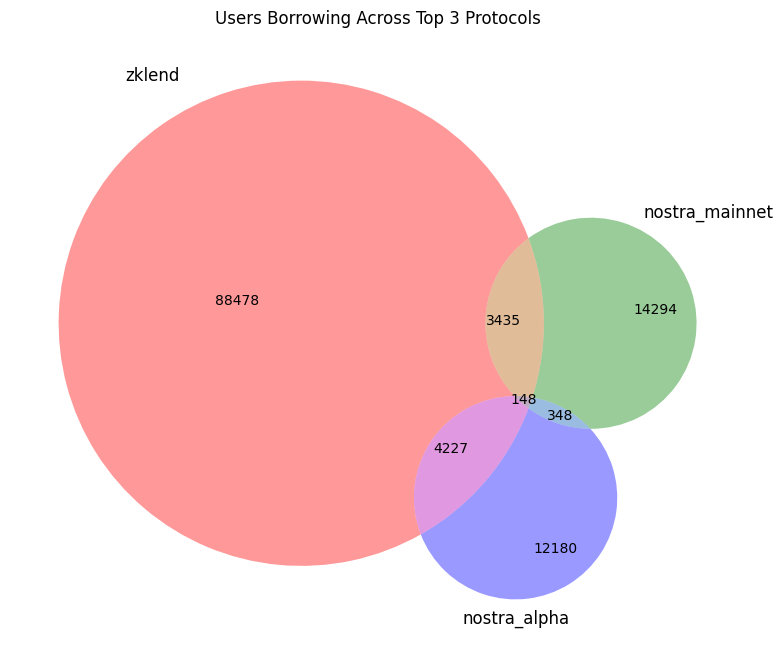

In [16]:
# Get unique users having debt
debt_df = df_loans[df_loans['Debt (USD)'] > 0]
debt_protocol_users = get_unique_users_by_protocol(debt_df)


# Prepare sets for Venn diagrams (top 3 protocols by user count)
top_3_protocols = top_protocols.keys()[:3]
debt_user_sets = [debt_protocol_users[protocol] for protocol in top_3_protocols]

# Plot Venn diagrams
plot_venn_diagram(debt_user_sets, 'Users Borrowing Across Top 3 Protocols', top_3_protocols)

#### Distribution of stacked/borrowed capital across Protocols

Protocol
hashstack_v0      3.385131e+03
hashstack_v1      1.996617e+05
nostra_alpha      1.661670e+05
nostra_mainnet    1.564581e+08
zklend            3.885571e+07
Name: Collateral (USD), dtype: float64


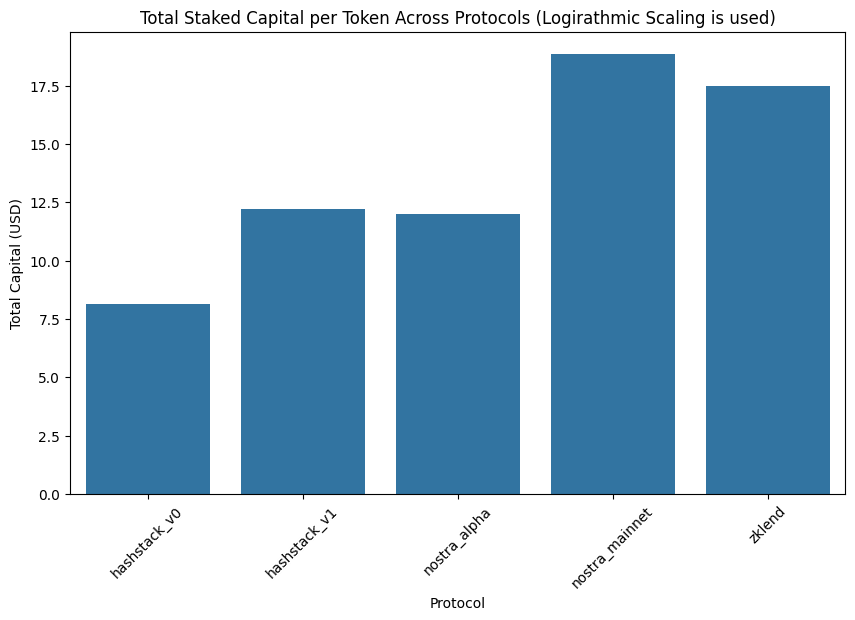

In [17]:
# Function to calculate total capital per token across protocols
def calculate_capital(df, column_name):
    capital_per_protocol = df.groupby('Protocol')[column_name].sum()
    return capital_per_protocol

# Function to plot bar chart for token capital across protocols
def plot_capital(capital, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=capital.index, y=np.log(capital.values))
    plt.xlabel('Protocol')
    plt.ylabel('Total Capital (USD)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Calculate total staked capital per token
staked_capital = calculate_capital(liquidity_df, 'Collateral (USD)')
print(staked_capital)
plot_capital(staked_capital, 'Total Staked Capital per Token Across Protocols (Logirathmic Scaling is used)')




#### Total capital borrowed per token

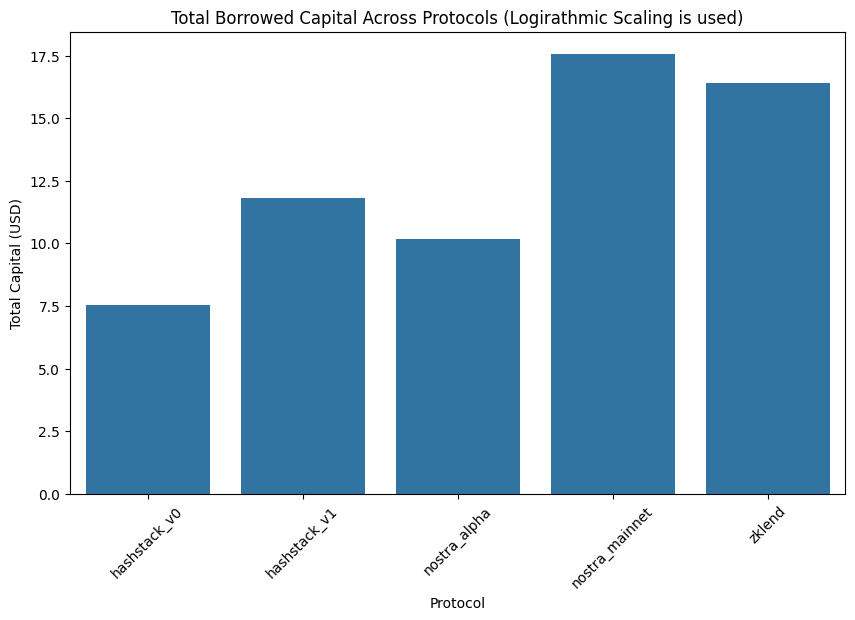

In [18]:
# Calculate total borrowed capital per token
borrowed_capital = calculate_capital(debt_df, 'Debt (USD)')
plot_capital(borrowed_capital, 'Total Borrowed Capital Across Protocols (Logirathmic Scaling is used)')

#### To Analyze the amounts stacked on a per token basis across the protocols

In [19]:
# List of tokens
tokens = ["ETH", "wBTC", "USDC", "DAI", "USDT", "wstETH", "LORDS", "STRK", "UNO", "ZEND"]

def parse_token_amounts(column, protocol_column, tokens):
    token_amounts = defaultdict(lambda: defaultdict(float))
    for entry, protocol in zip(column, protocol_column):
        for token in tokens:
            match = re.search(f'{token}: ([0-9.]+)', entry)
            if match:
                token_amounts[protocol][token] += float(match.group(1))
    return token_amounts

# Extract token amounts for collateral and debt
collateral_amounts = parse_token_amounts(df_loans['Collateral'], df_loans['Protocol'], tokens)
debt_amounts = parse_token_amounts(df_loans['Debt'], df_loans['Protocol'], tokens)

In [20]:
# agregating the data
# Convert the aggregated data to DataFrame for better readability
collateral_list = [(protocol, token, amount) for protocol, tokens in collateral_amounts.items() for token, amount in tokens.items()]
collateral_df = pd.DataFrame(collateral_list, columns=['Protocol', 'Token', 'Total Collateral (USD)'])

debt_list = [(protocol, token, amount) for protocol, tokens in debt_amounts.items() for token, amount in tokens.items()]
debt_df = pd.DataFrame(debt_list, columns=['Protocol', 'Token', 'Total Debt (USD)'])
print(collateral_df, debt_df, sep='\n')

          Protocol   Token  Total Collateral (USD)
0           zklend    USDC            6.481915e+06
1           zklend    USDT            3.356178e+06
2           zklend    STRK            1.239352e+07
3           zklend     ETH            4.235030e+03
4           zklend    wBTC            3.604780e+01
5           zklend     DAI            7.715796e+04
6           zklend  wstETH            5.272330e+01
7     nostra_alpha    USDC            4.002109e+04
8     nostra_alpha     ETH            3.202590e+01
9     nostra_alpha    USDT            3.019192e+04
10  nostra_mainnet     ETH            1.928400e+04
11  nostra_mainnet    USDC            1.720035e+07
12  nostra_mainnet     DAI            7.468461e+04
13  nostra_mainnet    USDT            1.256802e+07
14  nostra_mainnet  wstETH            5.437920e+01
15  nostra_mainnet    STRK            5.948398e+07
16  nostra_mainnet    wBTC            2.448470e+01
17  nostra_mainnet   LORDS            1.882704e+06
18    hashstack_v0    USDC     

#### Coverting to USD denominater

In [21]:
token_ids = []
for token in tokens:
    if token == 'DAI':
        token_ids.append('dai')
    elif token == 'ETH':
        token_ids.append('ethereum')
    elif token == 'USDC':
        token_ids.append('usd-coin')
    elif token == 'USDT':
        token_ids.append('tether')
    elif token == 'wBTC':
        token_ids.append('wrapped-bitcoin')
    elif token == 'LORDS':
        token_ids.append('lords')
    elif token == 'STRK':
        token_ids.append('strike')
    elif token == 'wstETH':
        token_ids.append('wrapped-steth')
    elif token == 'ZEND':
        token_ids.append('zenad')
    elif token == 'UNO':
        token_ids.append('uno-re')
#print(token_ids)

# Total Collateral (USD)
for token, token_id in zip(tokens,token_ids):
    val = collateral_df[collateral_df['Token'] == token].loc[:, 'Total Collateral (USD)'] * prices[token_id]['usd']
    collateral_df.loc[collateral_df['Token'] == token, 'Total Collateral (USD)'] = val
collateral_df

,Protocol,Token,Total Collateral (USD)
0,zklend,USDC,6.481915e+06
1,zklend,USDT,3.350375e+06
2,zklend,STRK,8.080574e+07
3,zklend,ETH,1.053561e+07
4,zklend,wBTC,2.416717e+06
5,zklend,DAI,7.715796e+04
6,zklend,wstETH,1.546912e+05
7,nostra_alpha,USDC,4.002109e+04
8,nostra_alpha,ETH,7.967179e+04
9,nostra_alpha,USDT,3.013972e+04


In [22]:
# Total Debt (USD)
for token, token_id in zip(tokens,token_ids):
    val = debt_df[debt_df['Token'] == token].loc[:, 'Total Debt (USD)'] * prices[token_id]['usd']
    debt_df.loc[debt_df['Token'] == token, 'Total Debt (USD)'] = val
debt_df

,Protocol,Token,Total Debt (USD)
0,zklend,ETH,3.232536e+06
1,zklend,USDC,4.787483e+06
2,zklend,USDT,2.112483e+06
3,zklend,wstETH,8.621471e+04
4,zklend,wBTC,3.809125e+05
5,zklend,DAI,6.299988e+04
6,zklend,STRK,1.268478e+07
7,nostra_alpha,USDT,4.953404e+03
8,nostra_alpha,wBTC,5.095192e+02
9,nostra_alpha,USDC,8.623691e+03


### Collateral data per protocol per token USD Equivalent

In [23]:
collateral_per_protocol_token = collateral_df.groupby(['Protocol','Token'])['Total Collateral (USD)'].sum()
collateral_per_protocol_token

Protocol        Token 
hashstack_v0    DAI       9.689930e+01
                ETH       1.508559e+03
                USDC      1.130584e+03
                USDT      2.264137e+02
                wBTC      1.340840e+02
hashstack_v1    DAI       5.764160e+02
                ETH       4.923143e+04
                USDC      4.014684e+04
                USDT      2.312818e+04
                wBTC      1.816838e+03
nostra_alpha    ETH       7.967179e+04
                USDC      4.002109e+04
                USDT      3.013972e+04
nostra_mainnet  DAI       7.468461e+04
                ETH       4.797338e+07
                LORDS     9.394610e+04
                STRK      3.878356e+08
                USDC      1.720035e+07
                USDT      1.254629e+07
                wBTC      1.641503e+06
                wstETH    1.595497e+05
zklend          DAI       7.715796e+04
                ETH       1.053561e+07
                STRK      8.080574e+07
                USDC      6.481915e+06
  

### Debt data per protocol per token USD Equivalent

In [24]:
debt_per_protocol_token = debt_df.groupby(['Protocol','Token'])['Total Debt (USD)'].sum()
debt_per_protocol_token

Protocol        Token 
hashstack_v0    DAI       1.601284e+02
                ETH       4.948095e+02
                USDC      8.258461e+02
                USDT      1.255433e+02
                wBTC      2.346470e+02
hashstack_v1    DAI       6.368208e+02
                ETH       4.072837e+04
                USDC      5.081960e+04
                USDT      3.365644e+04
                wBTC      1.602304e+03
nostra_alpha    DAI       1.949320e+03
                ETH       8.485398e+03
                USDC      8.623691e+03
                USDT      4.953404e+03
                wBTC      5.095192e+02
nostra_mainnet  DAI       5.101548e+04
                ETH       1.558572e+07
                LORDS     2.156724e+03
                STRK      4.047138e+07
                USDC      9.499169e+06
                USDT      6.826917e+06
                wBTC      7.908006e+05
                wstETH    1.014631e+05
zklend          DAI       6.299988e+04
                ETH       3.232536e+06
  

#### Data Visualization

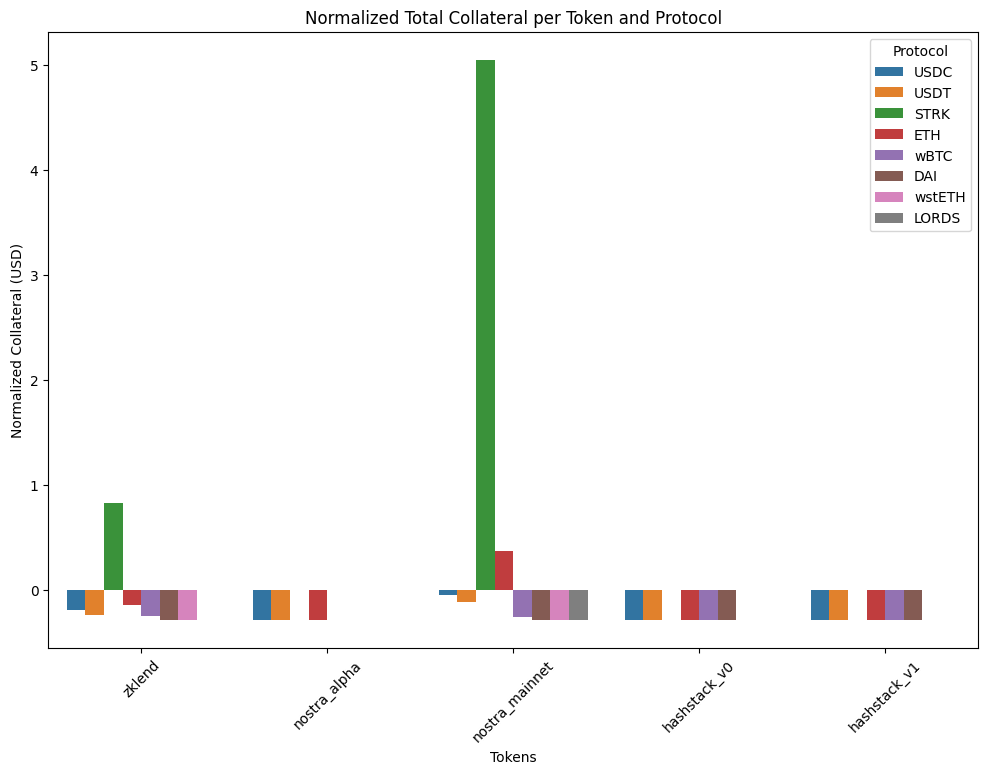

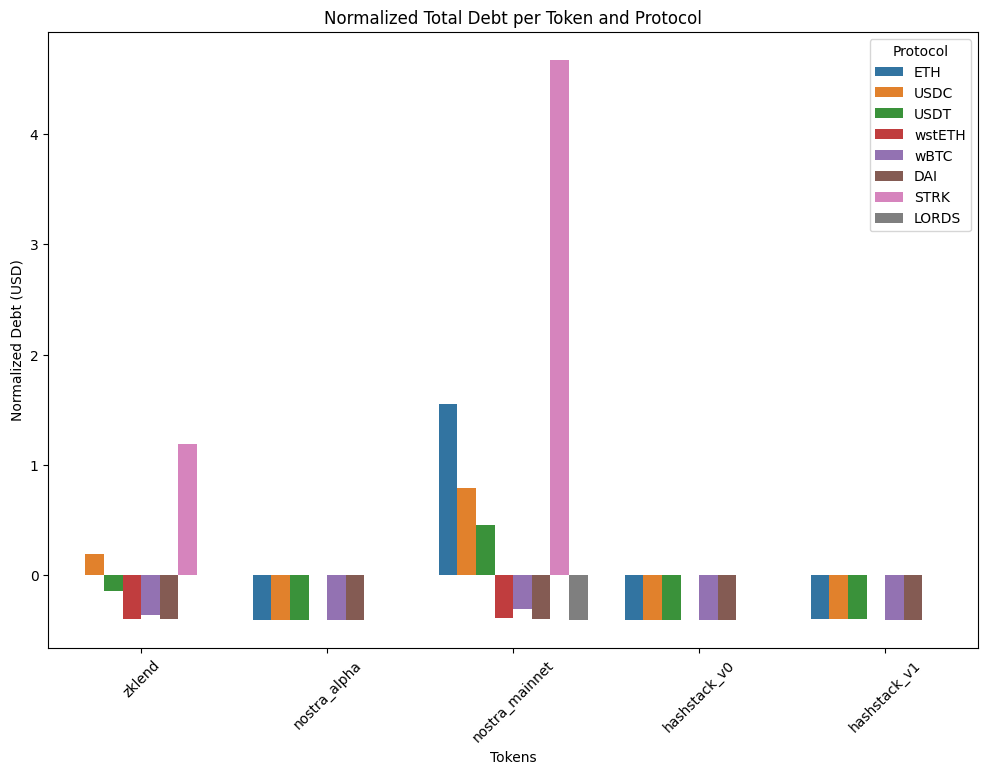

In [25]:
# Visualization

scaler = StandardScaler()
collateral_df['Normalized Collateral (USD)'] = scaler.fit_transform(collateral_df[['Total Collateral (USD)']])
debt_df['Normalized Debt (USD)'] = scaler.fit_transform(debt_df[['Total Debt (USD)']])

# Plotting collateral amounts
plt.figure(figsize=(12, 8))
sns.barplot(data=collateral_df, x='Protocol', y='Normalized Collateral (USD)', hue='Token')
plt.xlabel('Tokens')
plt.ylabel('Normalized Collateral (USD)')
plt.title('Normalized Total Collateral per Token and Protocol')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.show()

# Plotting debt amounts
plt.figure(figsize=(12, 8))
sns.barplot(data=debt_df, x='Protocol', y='Normalized Debt (USD)', hue='Token')
plt.xlabel('Tokens')
plt.ylabel('Normalized Debt (USD)')
plt.title('Normalized Total Debt per Token and Protocol')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.show()


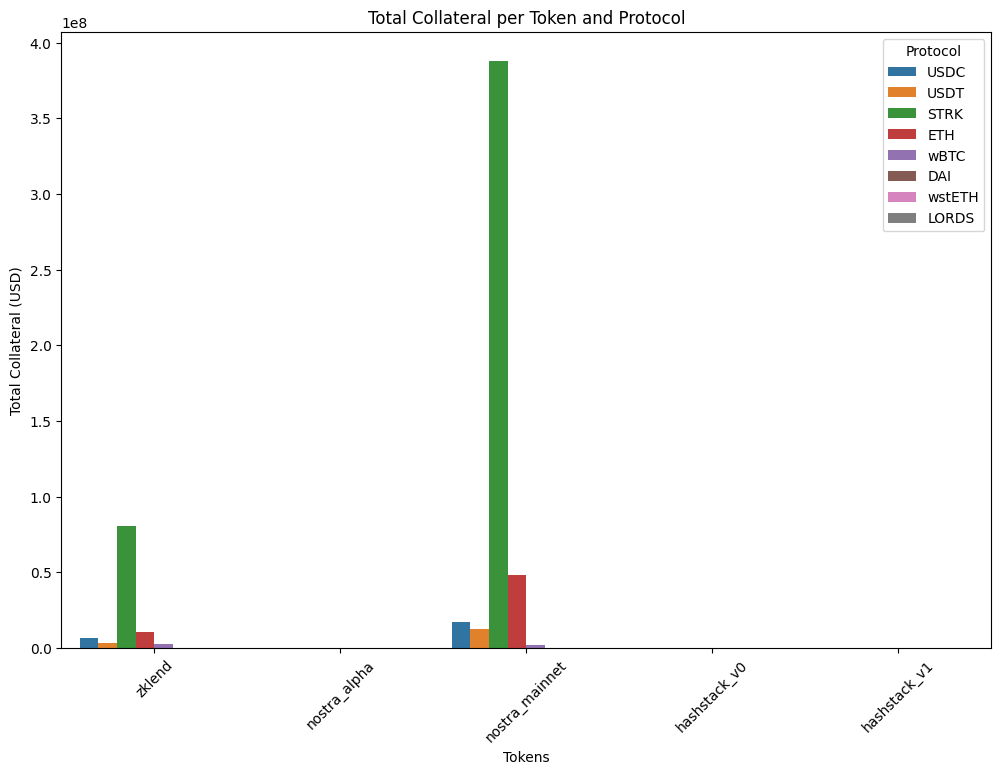

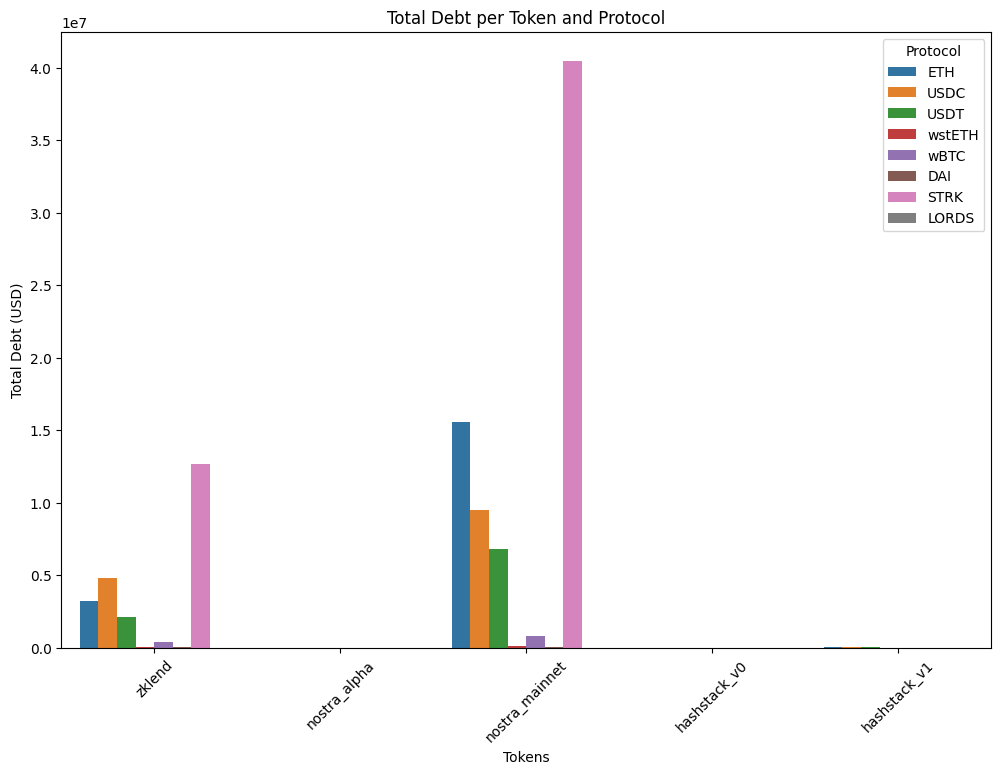

In [26]:
# Visualization
# Plotting collateral amounts
plt.figure(figsize=(12, 8))
sns.barplot(data=collateral_df, x='Protocol', y='Total Collateral (USD)', hue='Token')
plt.xlabel('Tokens')
plt.ylabel('Total Collateral (USD)')
plt.title('Total Collateral per Token and Protocol')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.show()

# Plotting debt amounts
plt.figure(figsize=(12, 8))
sns.barplot(data=debt_df, x='Protocol', y='Total Debt (USD)', hue='Token')
plt.xlabel('Tokens')
plt.ylabel('Total Debt (USD)')
plt.title('Total Debt per Token and Protocol')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.show()


## Conclusion

In this analysis, we addressed several questions regarding user interactions with DeFi protocols in terms of liquidity provision, borrowing, and capital distribution. Here are the key findings:

### 1. How many users provide liquidity on just 1 protocol? How many users use 2 or more protocols?
   - We found that the majority of users tend to provide liquidity on a **single protocol**, with a smaller subset of users participating in **multiple protocols**. This indicates a preference for consolidating liquidity on one platform, possibly due to familiarity, incentives, or protocol-specific advantages.

### 2. How many users borrow on just 1 protocol? How many users use 2 or more protocols?
   - Similar to liquidity provision, most users **borrow from a single protocol**. However, a minority of users engage with multiple borrowing protocols, likely optimizing for different collateral types, interest rates, or loan conditions.

### 3. Visualizing capital distribution across protocols if a user has 10k USD deposited in the pools.
   - We assumed that each user has deposited **10,000 USD** worth of capital and calculated how this capital is distributed across the protocols. The majority of users allocate most of their liquidity to a **single protocol**. This trend suggests that users tend to stake a significant portion of their capital in the protocol they trust most, with smaller amounts distributed across other platforms.

### 4. Capital distribution on a per-token basis.
   - The analysis shows significant variation in capital distribution across different tokens and protocols. 
     - **hashstack_v0**: Most of the capital is held in **USDC** (1130.58 USD) and **USDT** (226.81 USD), with smaller amounts in **DAI**, **ETH**, and **wBTC**.
     - **hashstack_v1**: The largest amounts are in **USDC** (40,146.84 USD) and **USDT** (23,168.24 USD), followed by **DAI**, **ETH**, and **wBTC**.
     - **nostra_alpha**: Significant collateral is in **USDC** (40,021.09 USD) and **USDT** (30,191.92 USD), with a moderate amount in **ETH**.
     - **nostra_mainnet**: A very large portion is allocated to **STRK** (59,483,980 USD) and **LORDS** (1,882,704 USD), with considerable amounts in **DAI** (74,684.61 USD), **USDC** (17,200,350 USD), and **USDT** (12,568,020 USD).
     - **zklend**: The largest holdings are in **STRK** (12,393,520 USD) and **USDC** (6,481,915 USD), with significant amounts in **DAI**, **ETH**, **USDT**, and **wBTC**.

   - **Stablecoins** like **USDC** and **USDT** dominate capital distribution across several protocols, while protocols such as **nostra_mainnet** and **zklend** have substantial holdings in **STRK** and **LORDS**. The diversity in token preferences reflects protocol-specific strategies and user preferences, with stablecoins being the preferred choice for liquidity in most protocols.


### Additional Insights:
   - **Venn diagrams** illustrated the overlap between users who provide liquidity or borrow from multiple protocols. The diagrams highlight that while most users are active on just one protocol, there is a meaningful overlap of users across two or more platforms.
   - **Token-based visualization** further showcased how liquidity and borrowing vary significantly based on token type, offering insights into protocol token preferences.

---

This analysis provides a clear understanding of how users interact with multiple DeFi protocols, how they distribute their capital, and which tokens and protocols are preferred. Further exploration could involve time-based analysis, exploring user behavior trends over time, or investigating protocol-specific incentives that drive user engagement across platforms.
